## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten
from openclsim.plot import get_step_chart, get_gantt_chart
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [6]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[vessel_name].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[vessel_name]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


# Example plots with 3 barges

In [7]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
res = run(3,total_amount)

vessels = res['vessels']
sites = res['sites']
activities = res['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]

CPU times: user 46.2 ms, sys: 5.14 ms, total: 51.3 ms
Wall time: 44.6 ms


In [8]:
fig = get_gantt_chart(vessels, id_map=activities)


In [9]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [10]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

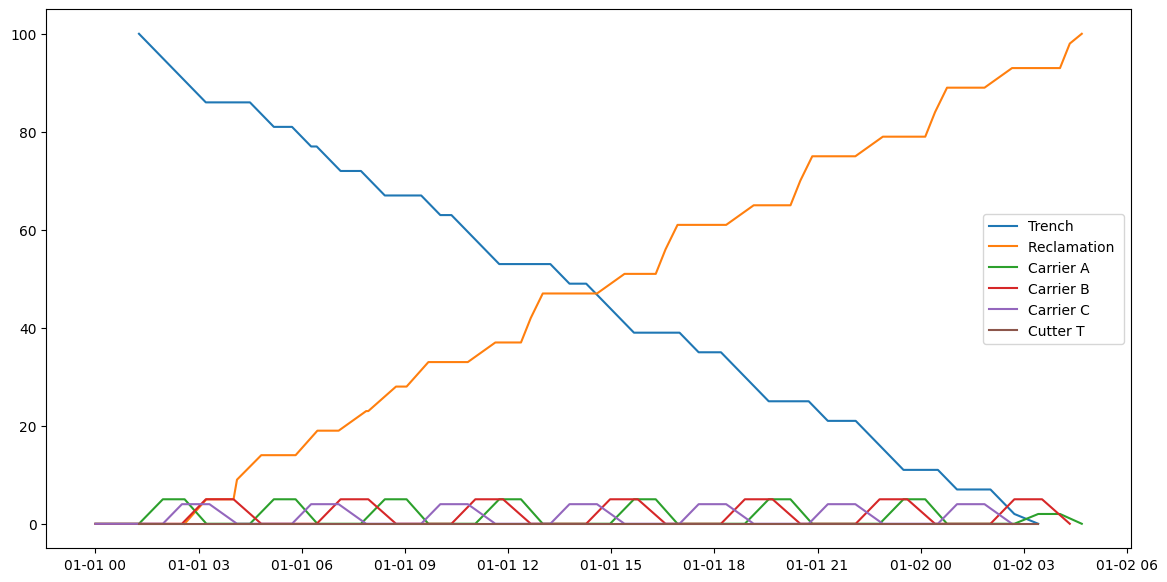

In [11]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

# Compare multiple barge scenarios

In [13]:
def occupancy_analysis(vessels, cutter, activities, vessel_cost):
    data = []
    duration_theory_cutter = 0
    nr_trips_cutter = 0

# barges
    
    for i, vessel_name in enumerate(vessels):
        if vessel_name!=cutter_name:
            vessel = vessels[vessel_name]
            activity = activities[f'activity{i}']

            log = pd.DataFrame(vessel.log)
            sub_act = activity.sub_processes[0].sub_processes[-1] # last phase of SequentialActivity ..
            nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "STOP")]) # .. ended
            nr_trips_cutter += nr_trips

            duration_theory = 0
            for sub_act in activity.sub_processes[0].sub_processes:
                duration_theory+=sub_act.duration
                if hasattr(sub_act,'processor'):
                    if sub_act.processor.name==cutter_name:
                        duration_theory_cutter += sub_act.duration*nr_trips

            duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
            data.append({
                'name':vessel.name, 
                '# trips':nr_trips, 
                'start': log.Timestamp.min(),
                'finish': log.Timestamp.max(),
                'duration actual': duration_actual,
                'cost':duration_actual*vessel_cost[vessel_name]/3600/24,
                'production actual':(nr_trips * sub_act.amount) / (duration_actual),
                'production theory': (sub_act.amount / (duration_theory)),
            })

# cutter
    
    log = pd.DataFrame(cutter.log)
    duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':cutter_name, 
        '# trips':nr_trips_cutter, 
        'start': log.Timestamp.min(),
        'finish': log.Timestamp.max(),
        'duration actual': duration_actual_cutter,
        'cost':duration_actual_cutter*vessel_cost[cutter_name]/3600/24,
        'production actual':(total_amount) / (duration_actual_cutter),
        'production theory':(total_amount) / (duration_theory_cutter),
    })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    print(f'Occupancy "{cutter_name}":', df.loc[cutter_name]['occupancy [%]'],'% Total cost',round(df['cost'].sum(),0))
    
    return df

In [16]:
results = []
occupancy = []
cost = []
finish, duration = [], []
n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    sites = results[-1]['sites']
    
    cutter = vessels[cutter_name]
    
    df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost'].sum())
    finish.append(df['finish'].max())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    display(df)

Occupancy "Cutter T": 41.5 % Total cost 52769.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,20,1970-01-01 01:24:46,1970-01-02 10:54:06,120560.0,34884.259259,0.000829,0.002000,41.5
Carrier A,10,1970-01-01 00:00:00,1970-01-02 11:12:00,126720.0,8800.000000,0.000395,0.000395,100.0
Carrier B,10,1970-01-01 00:00:00,1970-01-02 12:20:16,130816.0,9084.444444,0.000382,0.000389,98.2


Occupancy "Cutter T": 47.4 % Total cost 53778.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:19:32,1970-01-02 06:36:36,105424.0,30504.629630,0.000949,0.002000,47.4
Carrier A,9,1970-01-01 00:00:00,1970-01-02 05:41:32,106892.0,7423.055556,0.000337,0.000347,97.2
Carrier B,8,1970-01-01 00:00:00,1970-01-02 07:07:34,112054.0,7781.527778,0.000286,0.000293,97.5
Carrier C,8,1970-01-01 00:00:00,1970-01-02 08:16:26,116186.0,8068.472222,0.000275,0.000286,96.3


Occupancy "Cutter T": 73.9 % Total cost 40586.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:11:44,1970-01-01 20:44:24,70360.0,20358.796296,0.001421,0.001923,73.9
Carrier B,7,1970-01-01 00:00:00,1970-01-01 21:56:08,78968.0,5483.888889,0.000443,0.000450,98.5
Carrier A,6,1970-01-01 00:00:00,1970-01-01 19:53:20,71600.0,4972.222222,0.000335,0.000376,89.1
Barge I,5,1970-01-01 00:00:00,1970-01-01 20:55:44,75344.0,4360.185185,0.000332,0.000367,90.4
Carrier C,5,1970-01-01 00:00:00,1970-01-01 21:38:40,77920.0,5411.111111,0.000257,0.000296,86.7


Occupancy "Cutter T": 82.6 % Total cost 39201.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:23:30,1970-01-01 18:32:10,61720.0,17858.796296,0.001620,0.001961,82.6
Carrier A,5,1970-01-01 00:00:00,1970-01-01 18:05:12,65112.0,4521.666667,0.000384,0.000399,96.1
Carrier B,5,1970-01-01 00:00:00,1970-01-01 20:05:20,72320.0,5022.222222,0.000346,0.000365,94.6
Barge II,5,1970-01-01 00:00:00,1970-01-01 18:42:50,67370.0,3898.726852,0.000297,0.000319,93.0
Carrier C,4,1970-01-01 00:00:00,1970-01-01 16:53:28,60808.0,4222.777778,0.000263,0.000296,88.9
Barge I,4,1970-01-01 00:00:00,1970-01-01 17:38:54,63534.0,3676.736111,0.000252,0.000289,87.3


Occupancy "Cutter T": 100.0 % Total cost 35820.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:06:56,1970-01-01 15:25:16,51500.0,14901.620370,0.001942,0.001942,100.0
Carrier C,4,1970-01-01 00:00:00,1970-01-01 13:20:32,48032.0,3335.555556,0.000416,0.000475,87.7
Barge II,4,1970-01-01 00:00:00,1970-01-01 14:45:18,53118.0,3073.958333,0.000377,0.000467,80.6
Carrier B,4,1970-01-01 00:00:00,1970-01-01 16:50:46,60646.0,4211.527778,0.000330,0.000392,84.2
Barge I,3,1970-01-01 00:00:00,1970-01-01 14:28:16,52096.0,3014.814815,0.000288,0.000366,78.7
Barge III,4,1970-01-01 00:00:00,1970-01-01 15:57:46,57466.0,3325.578704,0.000278,0.000367,75.9
Carrier A,3,1970-01-01 00:00:00,1970-01-01 15:49:38,56978.0,3956.805556,0.000211,0.000287,73.3


Occupancy "Cutter T": 100.0 % Total cost 37700.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:12:34,1970-01-01 15:14:14,50500.0,14612.268519,0.001980,0.001980,100.0
Barge II,3,1970-01-01 00:00:00,1970-01-01 13:02:16,46936.0,2716.203704,0.000320,0.000395,80.9
Carrier C,4,1970-01-01 00:00:00,1970-01-01 14:38:28,52708.0,3660.277778,0.000304,0.000374,81.3
Barge I,3,1970-01-01 00:00:00,1970-01-01 13:44:02,49442.0,2861.226852,0.000303,0.000394,76.9
Carrier A,4,1970-01-01 00:00:00,1970-01-01 16:32:58,59578.0,4137.361111,0.000269,0.000349,76.9
Carrier B,3,1970-01-01 00:00:00,1970-01-01 16:15:32,58532.0,4064.722222,0.000256,0.000361,71.0
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:26:30,51990.0,2406.944444,0.000231,0.000301,76.6
Barge III,3,1970-01-01 00:00:00,1970-01-01 15:33:28,56008.0,3241.203704,0.000214,0.000301,71.3


Occupancy "Cutter T": 100.0 % Total cost 40372.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:07:48,1970-01-01 15:26:08,51500.0,14901.620370,0.001942,0.001942,100.0
Barge II,3,1970-01-01 00:00:00,1970-01-01 12:43:30,45810.0,2651.041667,0.000327,0.000455,71.9
Carrier A,4,1970-01-01 00:00:00,1970-01-01 15:27:16,55636.0,3863.611111,0.000288,0.000395,72.9
Barge I,3,1970-01-01 00:00:00,1970-01-01 13:19:14,47954.0,2775.115741,0.000250,0.000371,67.4
Carrier B,3,1970-01-01 00:00:00,1970-01-01 13:57:18,50238.0,3488.750000,0.000239,0.000353,67.7
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:43:58,53038.0,2455.462963,0.000226,0.000309,73.2
Extra 2,3,1970-01-01 00:00:00,1970-01-01 15:21:24,55284.0,2559.444444,0.000217,0.000298,72.9
Carrier C,3,1970-01-01 00:00:00,1970-01-01 16:29:36,59376.0,4123.333333,0.000202,0.000294,68.8
Barge III,3,1970-01-01 00:00:00,1970-01-01 17:03:24,61404.0,3553.472222,0.000195,0.000293,66.8


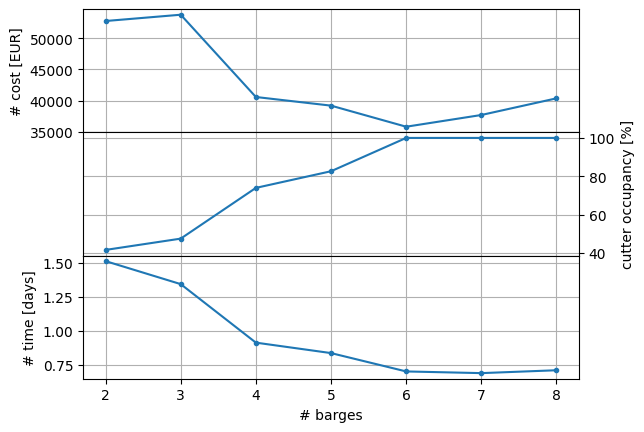

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(n_barges,cost,'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(n_barges,occupancy,'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(n_barges,duration,'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

## Visualize critical path of best scneario

For explanation of Critical Path see notebook 30

In [18]:
from openclsim.plot.critical_path import CpLog

In [19]:
i = 5 # many barges: close to 100% cutter config, small cost, fast delivery
vessels = results[i]['vessels']
activities = results[i]['activities']
sites = results[i]['sites']

cutter = vessels[cutter_name]
  
my_objects = list(vessels.values()) + list(sites.values())
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)

t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')

Occupancy "Cutter T": 100.0 % Total cost 37700.0
